## Homework 4

Use this notebook as a starter

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-09-27 12:30:24--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178,21K  --.-KB/s    in 0,07s   

2021-09-27 12:30:25 (2,47 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [48]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [49]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [50]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [51]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [52]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [53]:
categorical=list(df.dtypes[df.dtypes=='object'].index)
numerical=list(df.dtypes[df.dtypes!='object'].index)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

y_train=df_train.default.values
y_val=df_val.default.values
y_test=df_test.default.values

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [57]:
list_auc=[]
for num in numerical:
    nilai_auc=roc_auc_score(df_train['default'],df_train[num])
    list_auc.append(np.abs(nilai_auc) )
for i,j in zip(numerical,list_auc):
    print('%s : %.3f '%(i,j))

seniority : 0.291 
time : 0.561 
age : 0.427 
expenses : 0.499 
income : 0.318 
assets : 0.351 
debt : 0.495 
amount : 0.591 
price : 0.504 
default : 1.000 


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

time has the highest AUC 

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [58]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [59]:
usecols=['seniority', 'income', 'assets', 'records', 'job', 'home']
train_dicts=df_train[usecols].to_dict(orient='records')
dv=DictVectorizer(sparse=False)
dv.fit(train_dicts)

X_train=dv.transform(train_dicts)
model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [60]:
val_dicts=df_val[usecols].to_dict(orient='records')
X_val=dv.transform(val_dicts)
y_pred=model.predict_proba(X_val)[:,1]
print('AUC of this model on validation data set is %.3f '%(roc_auc_score(y_val,y_pred)) )

AUC of this model on validation data set is 0.812 


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

C:\Users\asus\AppData\Local\Temp/ipykernel_23164/1372205712.py:21: RuntimeWarning: invalid value encountered in long_scalars
  precision=tp/(tp+fp)


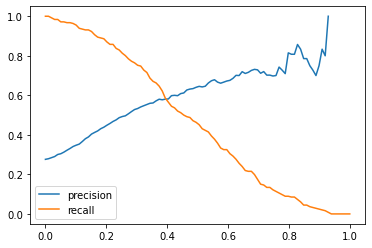

In [61]:
thresholds=np.linspace(0,1,100)

list_precision=[]
list_recall=[]

for t in thresholds:
    
    pred_positive=y_pred>=t
    pred_negative=y_pred<t
    
    actual_positive=y_val==1
    actual_negative=y_val==0
    
    tp=(pred_positive & actual_positive).sum()
    fp=(pred_positive & actual_negative).sum()
    
    tn=(pred_negative & actual_negative).sum()
    fn=(pred_negative & actual_positive).sum()
    
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
#     print('threshold:%.3f: tp:%.3f tn:%.3f fp:%.3f fn:%.3f r:%.3f p:%.3f '%(t,tp,tn,fp,fn,recall,precision))
    list_precision.append(precision)
    list_recall.append(recall)

list_precision=np.array(list_precision)
list_recall=np.array(list_recall)

plt.plot(thresholds,list_precision,label='precision')
plt.plot(thresholds,list_recall,label='recall')
plt.legend()


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

At threshold 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [62]:
list_f1=2* ( (list_precision * list_recall)/(list_precision + list_recall) )
list_f1=list(list_f1)
thresholds[list_f1.index(np.nanmax(list_f1))]

0.31313131313131315

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

threshold 0.3 make F1 maximal

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [63]:
def train(df_train,y_train,usecols,C=1,max_iter=1000):
    dicts=df_train[usecols].to_dict(orient='records')
    
    dv=DictVectorizer(sparse=False)
    X_train=dv.fit_transform(dicts)
    
    model=LogisticRegression(solver='liblinear',C=C,max_iter=max_iter)
    model.fit(X_train,y_train)
    
    return dv,model

def predict(df,dv,usecols,model):
    dicts=df[usecols].to_dict(orient='records')
    
    X=dv.transform(dicts)
    y_pred=model.predict_proba(X)[:,1]
    
    return y_pred

In [64]:
from sklearn.model_selection import KFold

In [65]:
kfold=KFold(n_splits=5,shuffle=True,random_state=1)
list_auc=[]
for train_idx,val_idx in kfold.split(df_full_train):
    df_train=df_full_train.iloc[train_idx]
    df_val=df_full_train.iloc[val_idx]
    
    y_train=df_train.default.values
    y_val=df_val.default.values
    
    dv,model=train(df_train,y_train,usecols)
    y_pred=predict(df_val,dv,usecols,model)
    
    auc=roc_auc_score(y_val,y_pred)
    
    list_auc.append(auc)
    
print('%.3f'%np.std(np.array(list_auc)))


0.014


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

The answer is 0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [66]:
list_mean=[]
list_std=[]
for C in [0.01, 0.1, 1, 10]:
    kfold=KFold(n_splits=5,shuffle=True,random_state=1)
    list_auc=[]
    for train_idx,val_idx in kfold.split(df_full_train):
        df_train=df_full_train.iloc[train_idx]
        df_val=df_full_train.iloc[val_idx]

        y_train=df_train.default.values
        y_val=df_val.default.values

        dv,model=train(df_train,y_train,usecols,C=C)
        y_pred=predict(df_val,dv,usecols,model)

        auc=roc_auc_score(y_val,y_pred)

        list_auc.append(auc)
    print('C=%s %.3f +-%.3f '%(C,np.mean(np.array(list_auc)),np.std(np.array(list_auc)) ))
    list_mean.append(np.mean(np.array(list_auc)))
    list_std.append(np.std(np.array(list_auc)))

C=0.01 0.808 +-0.012 
C=0.1 0.813 +-0.014 
C=1 0.812 +-0.014 
C=10 0.814 +-0.015 


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

C=10 have the best mean score

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.